In [62]:
import numpy as np
from load_mnist import mnist
from load_mnist import one_hot
%matplotlib inline 
import matplotlib.pyplot as plt
import pdb
import pandas as pd
import sys, ast
from sklearn.model_selection import train_test_split
import pickle
import gc

count=0

def relu(Z):
    A = np.maximum(0,Z)
    cache = {}
    cache["Z"] = Z
    return A, cache

def relu_der(dA, cache):
    dZ = np.array(dA, copy=True)
    Z = cache["Z"]
    dZ[Z<0] = 0
    return dZ

def load_data(filename1, filename2, type):
    if type == 'train':
        loaded = np.fromfile(file=filename1, dtype=np.uint8)
        trData = loaded[16:].reshape((60000, 28*28)).astype(float)
        loaded = np.fromfile(filename2, dtype=np.uint8)
        trLabels = loaded[8:].reshape(60000).astype(float)
        return trData, trLabels
    else:
        loaded = np.fromfile(file=filename1, dtype=np.uint8)
        tsData = loaded[16:].reshape((10000, 28 * 28)).astype(float)
        loaded = np.fromfile(filename2, dtype=np.uint8)
        tsLabels = loaded[8:].reshape((10000)).astype(float)
        return tsData, tsLabels

def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = {}
    cache["Z"] = Z
    return A, cache

def sigmoid_der(dA, cache):
    tempA,temp = sigmoid(cache["Z"])
    dZ = dA * tempA * (1-tempA)####newCode
    return dZ

def get_loss(AL,Y):
    diff = AL - Y
    '''Mean_Squared_Error'''
    cost = np.mean(np.multiply(diff, diff))
    '''Cross Entropy Loss'''
    if Y.shape[1] == 0:
        loss = []
    else:
        loss = -np.sum(Y*np.log(AL+1e-8))/ AL.shape[0]
    return cost,diff,loss

def initialize_multilayer_weights(net_dims):
    np.random.seed(0)
    numLayers = int(len(net_dims))
    parameters = {}
    for l in range(numLayers-1):
        parameters["W"+str(l+1)] = (np.random.normal(0, np.sqrt(2.0/net_dims[l]),(net_dims[l],net_dims[l+1]))) #0.01*np.random.randn(net_dims[l+1],net_dims[l])
        parameters["b"+str(l+1)] = (np.random.normal(0, np.sqrt(2.0/net_dims[l]), (net_dims[l+1]))) #0.01*np.zeros((net_dims[l+1],1))
    return parameters

def linear_forward(A, W, b):
    Z=np.dot(A,W) + b
    cache = {}
    cache["A"] = A
    return Z, cache

def layer_forward(A_prev, W, b, activation):
    Z, lin_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, act_cache = relu(Z)
    elif activation == "linear":
        A, act_cache = linear(Z)
    elif activation == "sigmoid":
        A, act_cache = sigmoid(Z)
    
    cache = {}
    cache["lin_cache"] = lin_cache
    cache["act_cache"] = act_cache
    return A, cache

def multi_layer_forward(X, parameters):
    L = len(parameters)//2
    A = X
    caches = []
    for l in range(1,(L)):  # since there is no W0 and b0
        A, cache = layer_forward(A, parameters["W"+str(l)], parameters["b"+str(l)], "sigmoid")
        caches.append(cache)
    AL, cache = layer_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid")
    caches.append(cache)
    return AL, caches

def linear_backward(dZ, cache, W, b):
    A= cache["A"]
    dA_prev = np.dot(dZ,W.T)
    dW = np.dot(A.T,dZ) / A.shape[0]
    db = np.sum(dZ,axis = 0 , keepdims = True) / A.shape[1]
    return dA_prev, dW, db

def layer_backward(dA, cache, W, b, activation):
    lin_cache = cache["lin_cache"]
    act_cache = cache["act_cache"]

    if activation == "sigmoid":
        dZ = sigmoid_der(dA, act_cache)
    elif activation == "tanh":
        dZ = tanh_der(dA, act_cache)
    elif activation == "relu":
        dZ = relu_der(dA, act_cache)
    elif activation == "linear":
        dZ = linear_der(dA, act_cache)
    dA_prev, dW, db = linear_backward(dZ, lin_cache, W, b)
    return dA_prev, dW, db

def multi_layer_backward(dAL, caches, parameters):
    L = len(caches)  # with one hidden layer, L = 2
    gradients = {}
    dA = dAL
    activation = "sigmoid"
    for l in reversed(range(L,L+1)):
        dA, gradients["dW"+str(l)], gradients["db"+str(l)] = \
                    layer_backward(dA, caches[l-1], \
                    parameters["W"+str(l)],parameters["b"+str(l)],\
                    activation)
        activation = "sigmoid"
    
    activation = "sigmoid"
    for l in reversed(range(1,L)):
        dA, gradients["dW"+str(l)], gradients["db"+str(l)] = \
                    layer_backward(dA, caches[l-1], \
                    parameters["W"+str(l)],parameters["b"+str(l)],\
                    activation)
        activation = "sigmoid"
    return gradients

def classify(X, parameters):
    A , _ = multi_layer_forward(X, parameters)
    return A

def update_parameters(parameters, gradients, epoch, learning_rate, decay_rate=0.001):
    alpha = learning_rate*(1/(1+decay_rate*epoch))
    L = len(parameters)//2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - alpha * gradients["dW"+ str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - alpha * gradients["db"+ str(l+1)]
    return parameters, alpha

def multi_layer_network(X, Y, val_data_noisy, val_data, net_dims,batch,noise,num_iterations=500, learning_rate=0.2, decay_rate=0.001):
    parameters = initialize_multilayer_weights(net_dims)
    A0 = X
    print("Train data is")
    plt.imshow(Y[0].reshape(28, 28))
    plt.show()
    costs = []
    print("THe batch is",batch)
    validation_error=[]
    iteration_list=[]
    mini_batch=batch
    num_iterations=num_iterations
    for ii in range(num_iterations):
        X_mini=[]
        #np.random.shuffle(A0)
        for g in range(0, A0.shape[0], mini_batch):
            X_mini=A0[g:g + mini_batch]
            AL, caches = multi_layer_forward(A0, parameters)
            cost,dz,loss=get_loss(AL,Y)
            gradients = multi_layer_backward(dz, caches, parameters)
            parameters,alpha = update_parameters(parameters, gradients, ii, learning_rate,decay_rate)
#             print("Yo")
        costs.append(cost)
        train_output=classify(X,parameters)
        val_output=classify(val_data_noisy,parameters)
        cost_val,dz_val,loss_val=get_loss(val_output,val_data)
        validation_error.append(cost_val)
        
        iteration_list.append(ii)
        if ii % 10 == 0:
            print("MSE Cost at iteration %i is: %.05f" %(ii, cost))
            print("MSE Cost at iteration %i validation error is %.05f" %(ii,cost_val))
            print("Cross entropy Cost at iteration %i is: %.05f" %(ii, loss))
            print("Cross entropy Cost at iteration %i validation error is %.05f" %(ii,loss_val))
            print("Train data noisy")
            plt.imshow(X[0].reshape(28, 28))
            plt.show()
            print("Train data predicted")
            plt.imshow(train_output[0].reshape(28, 28))
            plt.show()
            print("validation data noisy")
            plt.imshow(val_data[0].reshape(28, 28))
            plt.show()
            print("validation data predicted")
            plt.imshow(val_output[0].reshape(28, 28))
            plt.show()
            
    plt.plot(iteration_list, costs, label="Training data", linestyle='solid', color="red")
    plt.plot(iteration_list, validation_error, label="Validation data", linestyle='solid', color="blue")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss for 1000 hidden nodes for " +str(num_iterations) +" iterations,noise is "+noise)
    plt.legend(['Training data','Validation data'])
    plt.show()
    
    
    return costs, parameters, validation_error

def noisy_data(X):
    # creating the noisy test data by adding X with noise
    n_rows = X.shape[0]
    n_cols = X.shape[1]
    mean = 0.5
    stddev = 0.3
    noise = np.random.normal(mean, stddev, (n_rows, n_cols))
    return (X + (noise*0.5))
    
def add_speckle_noise(data):
    gauss = np.random.randn(data.shape[0],data.shape[1])
    gauss = gauss.reshape(data.shape[0],data.shape[1])
    noisy = data + (data * gauss)*0.5
    return noisy
    
def add_poisson_noise(data):
    vals = len(np.unique(data))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(data * (vals*0.5)) / (float(vals)*0.5)
    return noisy

def main(noise,hidden_nodes,learning_rate,batch,iterations):
    global count
    n_in= 784
    n_h1 = hidden_nodes #hidden_nodes
    net_dims = [n_in, n_h1]
    
    net_dims.append(784) # Adding the digits layer with dimensionality = 10
    print("Network dimensions are:" + str(net_dims))
    learning_rate = learning_rate
    print("learning Rate is: ",learning_rate)
    num_iterations = iterations
    data_directory = 'D:/ASU/Sem 3/FSL/Final Project/FashionMNIST/'
    train, train_label = load_data(data_directory + "train-images-idx3-ubyte", data_directory +"train-labels-idx1-ubyte", 'train')
    test_data, test_label = load_data(data_directory + "t10k-images-idx3-ubyte", data_directory +"t10k-labels-idx1-ubyte", 'test')
    train_x = train / 255
    
    ## create train and validation datasets
    train_x, val_x, = train_test_split(train_x, test_size=0.2)
    ## reshape the inputs
    train_x = train_x.reshape(-1, 784)
    val_x = val_x.reshape(-1, 784)
    train_data=train_x
    val_data=val_x
    if(noise=='gaussian'):
        train_data_noisy=noisy_data(train_data)
        test_data_noisy=noisy_data(test_data)
        val_data_noisy=noisy_data(val_data)
    elif(noise=='speckle'):
        train_data_noisy=add_speckle_noise(train_data)
        test_data_noisy=add_speckle_noise(test_data)
        val_data_noisy=add_speckle_noise(val_data)
    elif(noise=='poisson'):
        train_data_noisy=add_poisson_noise(train_data)
        test_data_noisy=add_poisson_noise(test_data)
        val_data_noisy=add_poisson_noise(val_data)   
    decay_rate=0.001

    costs, parameters, validation_error = multi_layer_network(train_data_noisy, train_data, val_data_noisy, val_data, net_dims,batch,noise,num_iterations, learning_rate,decay_rate)
    
    dict_parameters={"parameters" : parameters}
    pickle_out= open("parameters"+str(count)+".pickle","wb")
    pickle.dump(dict_parameters,pickle_out)
    pickle_out.close()
    count+=1
    # compute the accuracy for training set and testing set
    train_Pred = classify(train_data_noisy, parameters)    
    test_Pred = classify(test_data_noisy, parameters)
    
    print('Train data noiseless and noisy')
    plt.imshow(train_data[0].reshape(28, 28))
    plt.show()
    plt.imshow(train_data_noisy[0].reshape(28, 28))
    plt.show()
    plt.imshow(train_Pred[0].reshape(28, 28))
    plt.show()
     
    print('Val data noiseless and noisy')
    plt.imshow(test_data[0].reshape(28, 28))
    plt.show()
    plt.imshow(test_data_noisy[0].reshape(28, 28))
    plt.show()
    plt.imshow(test_Pred[0].reshape(28, 28))
    plt.show()
    gc.collect()

noise: gaussian, hidden_nodes: 1000, learning_rate : 0.1, batch :60000, number of iteration :100
Network dimensions are:[784, 1000, 784]
learning Rate is:  0.1
Train data is


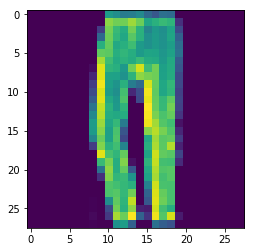

THe batch is 60000
MSE Cost at iteration 0 is: 0.19949
MSE Cost at iteration 0 validation error is 0.09970
Cross entropy Cost at iteration 0 is: 170.39204
Cross entropy Cost at iteration 0 validation error is 267.33838
Train data noisy


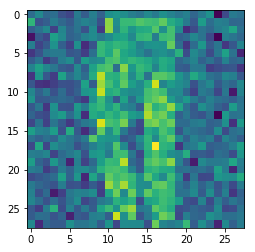

Train data predicted


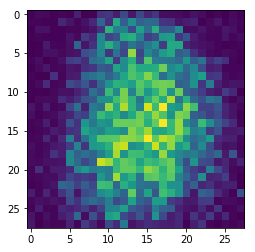

validation data noisy


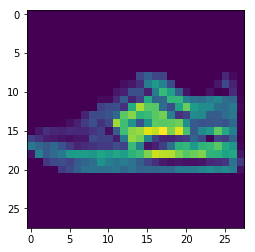

validation data predicted


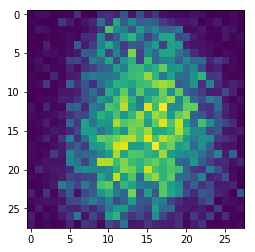

MSE Cost at iteration 10 is: 0.08032
MSE Cost at iteration 10 validation error is 0.07904
Cross entropy Cost at iteration 10 is: 207.39190
Cross entropy Cost at iteration 10 validation error is 205.48726
Train data noisy


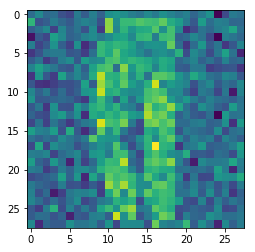

Train data predicted


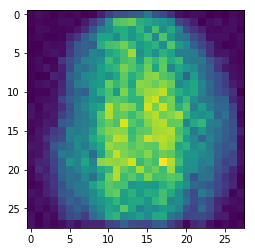

validation data noisy


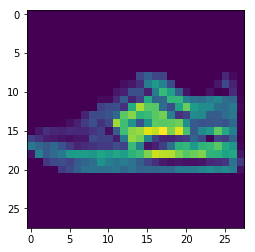

validation data predicted


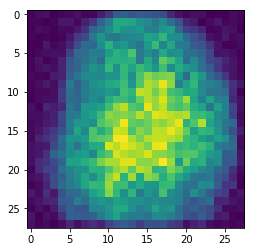

MSE Cost at iteration 20 is: 0.07238
MSE Cost at iteration 20 validation error is 0.07537
Cross entropy Cost at iteration 20 is: 175.15520
Cross entropy Cost at iteration 20 validation error is 227.16475
Train data noisy


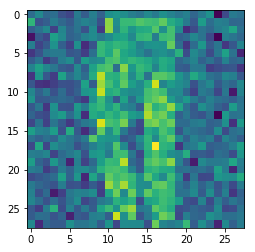

Train data predicted


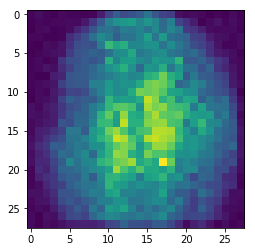

validation data noisy


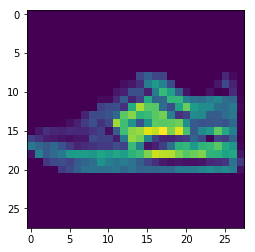

validation data predicted


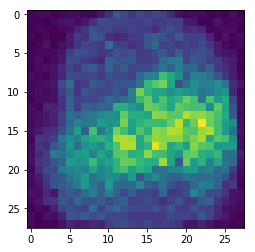

MSE Cost at iteration 30 is: 0.06801
MSE Cost at iteration 30 validation error is 0.06752
Cross entropy Cost at iteration 30 is: 158.68189
Cross entropy Cost at iteration 30 validation error is 216.39325
Train data noisy


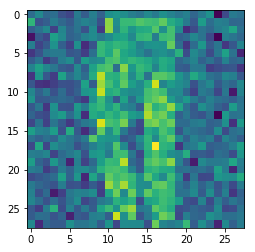

Train data predicted


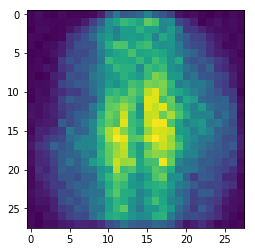

validation data noisy


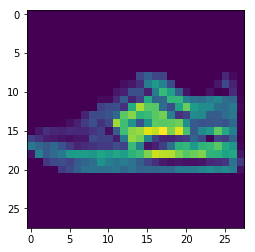

validation data predicted


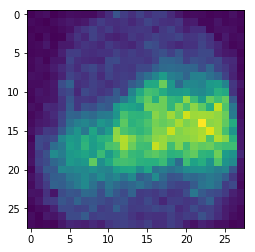

MSE Cost at iteration 40 is: 0.06341
MSE Cost at iteration 40 validation error is 0.06211
Cross entropy Cost at iteration 40 is: 136.55870
Cross entropy Cost at iteration 40 validation error is 218.56632
Train data noisy


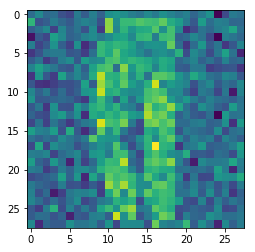

Train data predicted


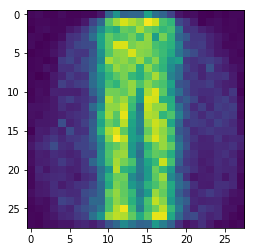

validation data noisy


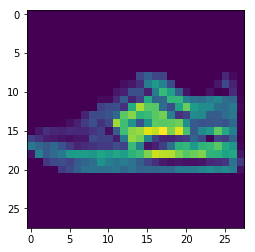

validation data predicted


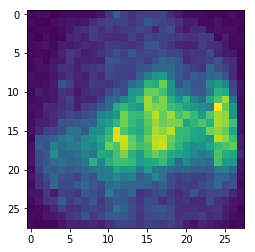

MSE Cost at iteration 50 is: 0.05638
MSE Cost at iteration 50 validation error is 0.05611
Cross entropy Cost at iteration 50 is: 141.77400
Cross entropy Cost at iteration 50 validation error is 200.99028
Train data noisy


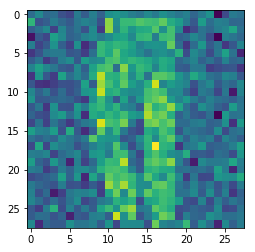

Train data predicted


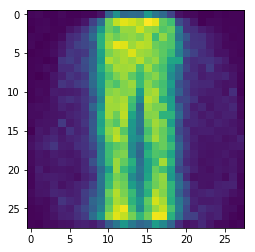

validation data noisy


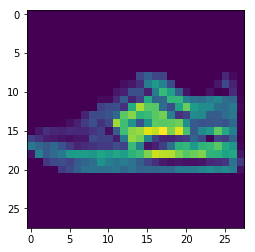

validation data predicted


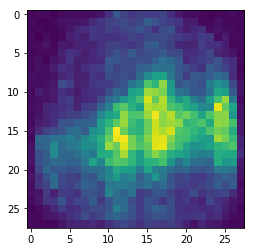

MSE Cost at iteration 60 is: 0.05654
MSE Cost at iteration 60 validation error is 0.05507
Cross entropy Cost at iteration 60 is: 126.55422
Cross entropy Cost at iteration 60 validation error is 207.57213
Train data noisy


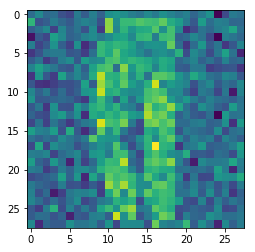

Train data predicted


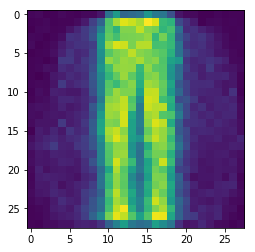

validation data noisy


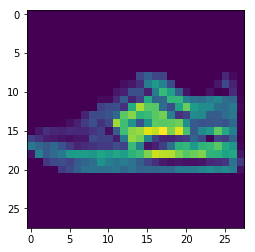

validation data predicted


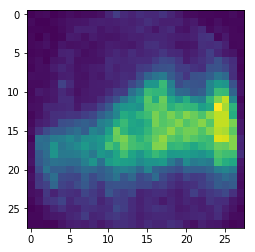

MSE Cost at iteration 70 is: 0.05232
MSE Cost at iteration 70 validation error is 0.05194
Cross entropy Cost at iteration 70 is: 126.52268
Cross entropy Cost at iteration 70 validation error is 201.41946
Train data noisy


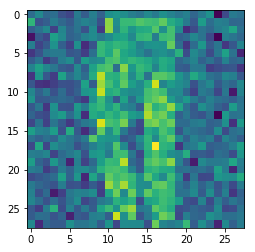

Train data predicted


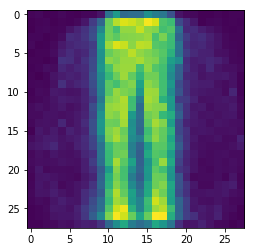

validation data noisy


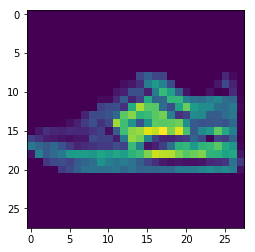

validation data predicted


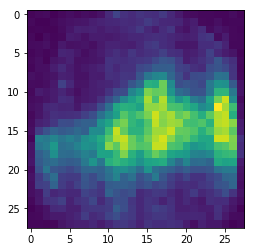

MSE Cost at iteration 80 is: 0.04925
MSE Cost at iteration 80 validation error is 0.04878
Cross entropy Cost at iteration 80 is: 127.35930
Cross entropy Cost at iteration 80 validation error is 193.44095
Train data noisy


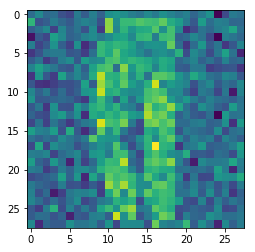

Train data predicted


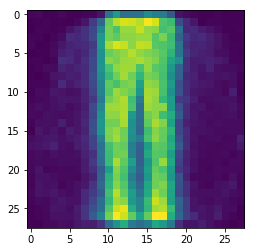

validation data noisy


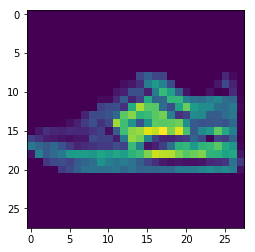

validation data predicted


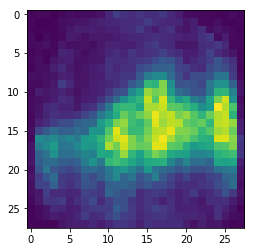

MSE Cost at iteration 90 is: 0.04815
MSE Cost at iteration 90 validation error is 0.04716
Cross entropy Cost at iteration 90 is: 121.72253
Cross entropy Cost at iteration 90 validation error is 192.56959
Train data noisy


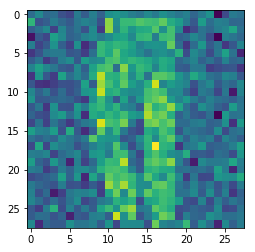

Train data predicted


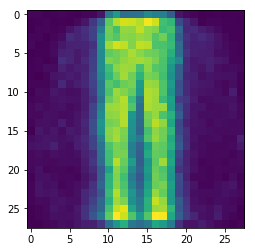

validation data noisy


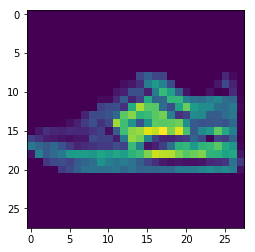

validation data predicted


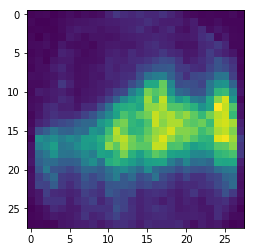

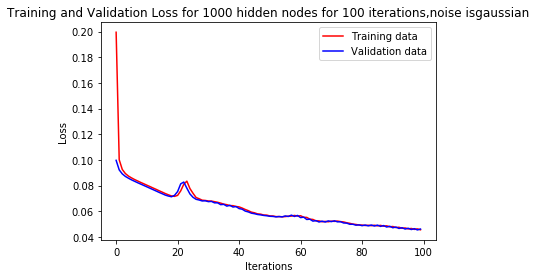

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in exp


Train data noiseless and noisy


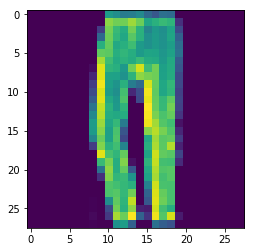

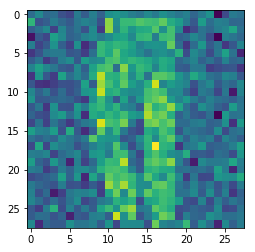

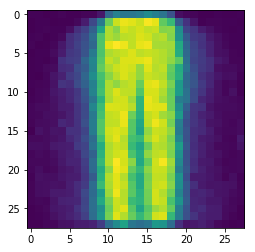

Val data noiseless and noisy


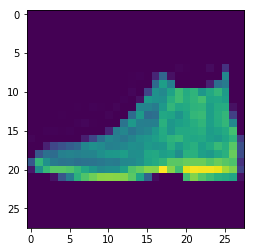

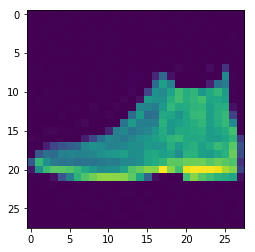

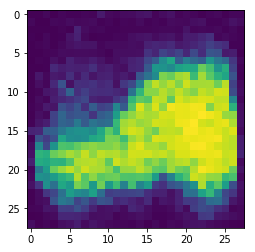

In [54]:
if __name__ == "__main__":
    gc.collect()
    print("noise: gaussian, hidden_nodes: 1000, learning_rate : 0.1, batch :60000, number of iteration :100")
    main("gaussian",1000,0.1,60000,100)

noise: speckle, hidden_nodes: 1000, learning_rate : 0.1, batch : 60000, number of iteration : 100
Network dimensions are:[784, 1000, 784]
learning Rate is:  0.1
Train data is


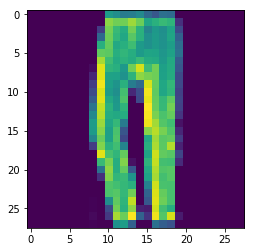

THe batch is 60000
MSE Cost at iteration 0 is: 0.19574
MSE Cost at iteration 0 validation error is 0.09366
Cross entropy Cost at iteration 0 is: 168.56834
Cross entropy Cost at iteration 0 validation error is 249.45043
Train data noisy


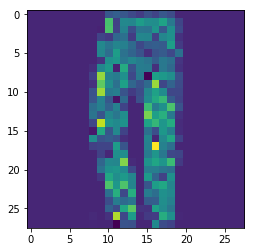

Train data predicted


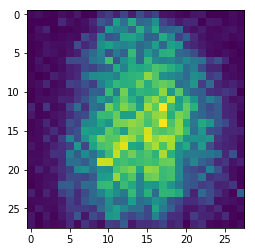

validation data noisy


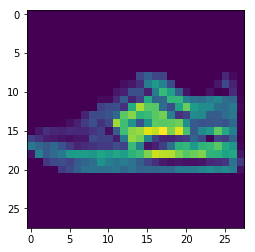

validation data predicted


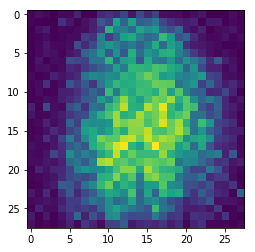

MSE Cost at iteration 10 is: 0.07420
MSE Cost at iteration 10 validation error is 0.07250
Cross entropy Cost at iteration 10 is: 199.89124
Cross entropy Cost at iteration 10 validation error is 196.77894
Train data noisy


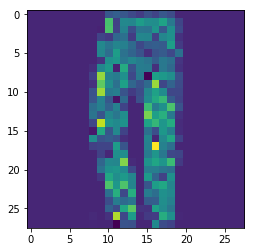

Train data predicted


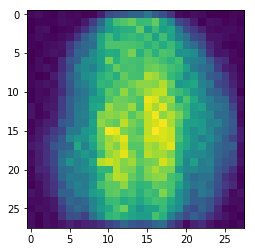

validation data noisy


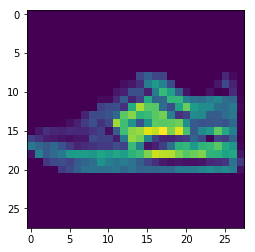

validation data predicted


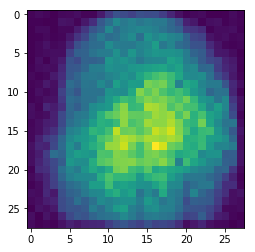

MSE Cost at iteration 20 is: 0.06019
MSE Cost at iteration 20 validation error is 0.05897
Cross entropy Cost at iteration 20 is: 180.33410
Cross entropy Cost at iteration 20 validation error is 178.62227
Train data noisy


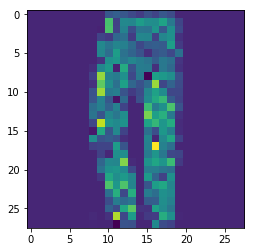

Train data predicted


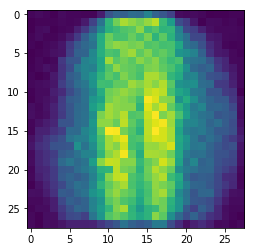

validation data noisy


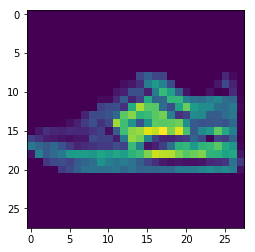

validation data predicted


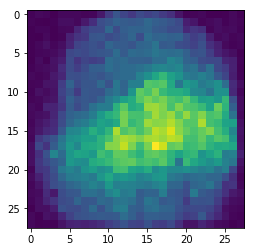

MSE Cost at iteration 30 is: 0.05135
MSE Cost at iteration 30 validation error is 0.05068
Cross entropy Cost at iteration 30 is: 167.60395
Cross entropy Cost at iteration 30 validation error is 166.64834
Train data noisy


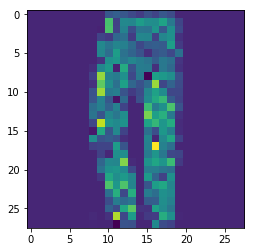

Train data predicted


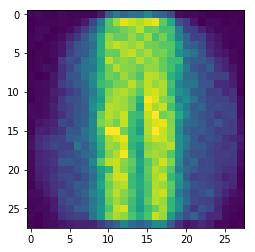

validation data noisy


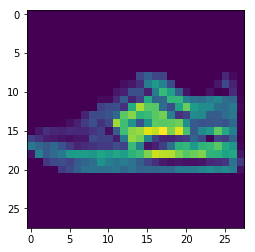

validation data predicted


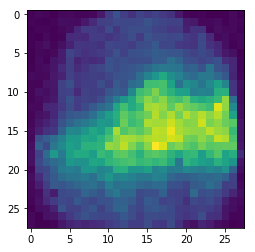

MSE Cost at iteration 40 is: 0.04639
MSE Cost at iteration 40 validation error is 0.04601
Cross entropy Cost at iteration 40 is: 159.95505
Cross entropy Cost at iteration 40 validation error is 159.37601
Train data noisy


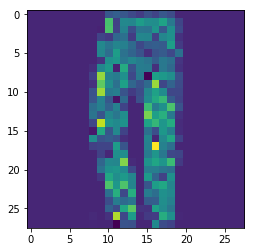

Train data predicted


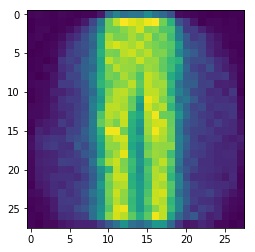

validation data noisy


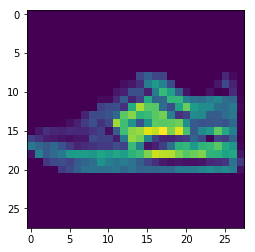

validation data predicted


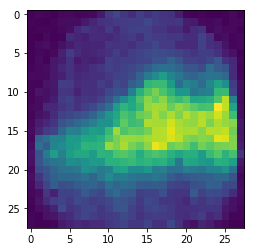

MSE Cost at iteration 50 is: 0.04339
MSE Cost at iteration 50 validation error is 0.04316
Cross entropy Cost at iteration 50 is: 155.13410
Cross entropy Cost at iteration 50 validation error is 154.82028
Train data noisy


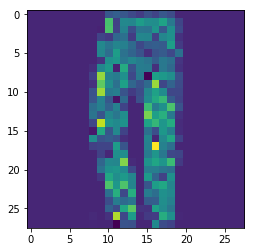

Train data predicted


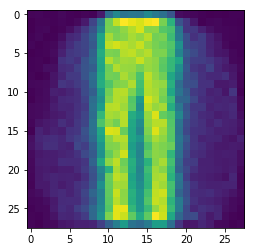

validation data noisy


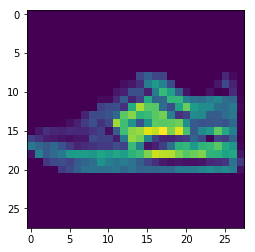

validation data predicted


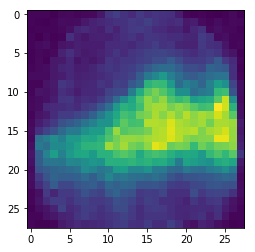

MSE Cost at iteration 60 is: 0.04130
MSE Cost at iteration 60 validation error is 0.04113
Cross entropy Cost at iteration 60 is: 151.80191
Cross entropy Cost at iteration 60 validation error is 151.67203
Train data noisy


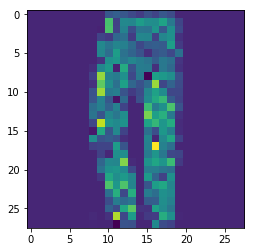

Train data predicted


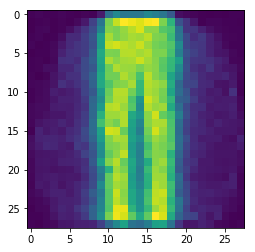

validation data noisy


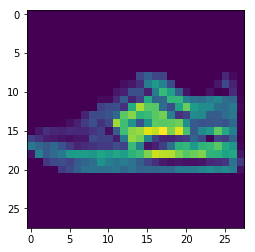

validation data predicted


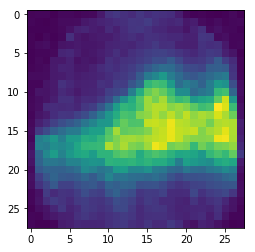

MSE Cost at iteration 70 is: 0.03962
MSE Cost at iteration 70 validation error is 0.03949
Cross entropy Cost at iteration 70 is: 149.23625
Cross entropy Cost at iteration 70 validation error is 149.22348
Train data noisy


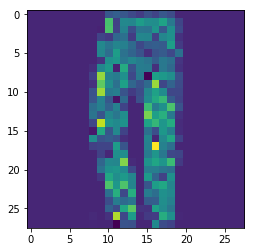

Train data predicted


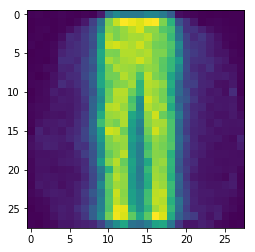

validation data noisy


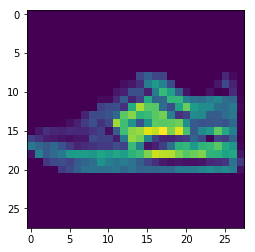

validation data predicted


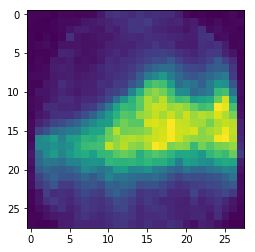

MSE Cost at iteration 80 is: 0.03816
MSE Cost at iteration 80 validation error is 0.03805
Cross entropy Cost at iteration 80 is: 147.07514
Cross entropy Cost at iteration 80 validation error is 147.13691
Train data noisy


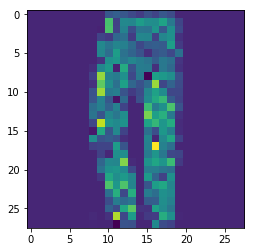

Train data predicted


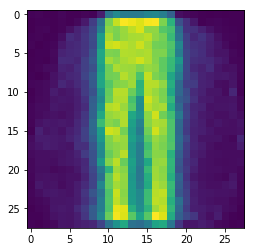

validation data noisy


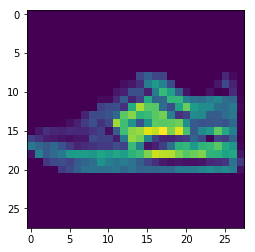

validation data predicted


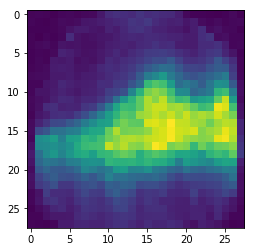

MSE Cost at iteration 90 is: 0.03685
MSE Cost at iteration 90 validation error is 0.03676
Cross entropy Cost at iteration 90 is: 145.14862
Cross entropy Cost at iteration 90 validation error is 145.26094
Train data noisy


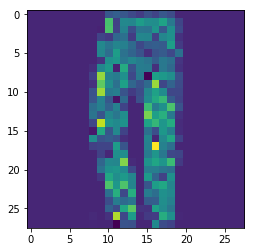

Train data predicted


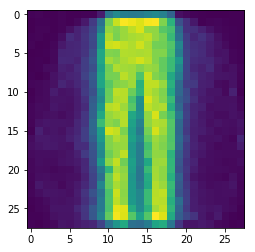

validation data noisy


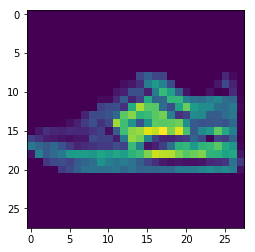

validation data predicted


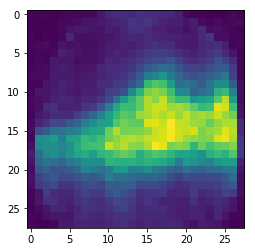

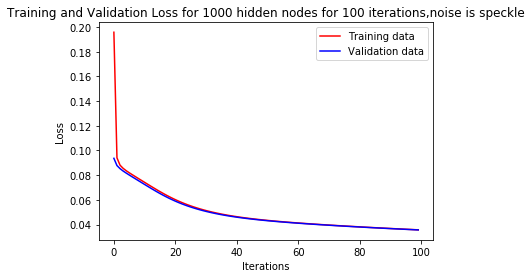

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in exp


Train data noiseless and noisy


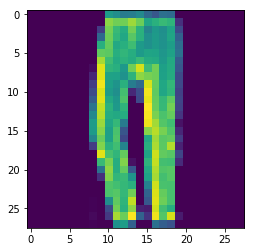

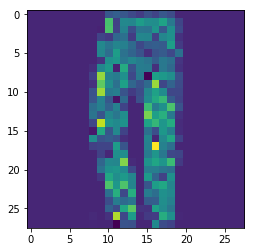

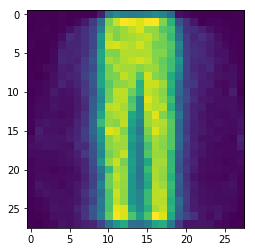

Val data noiseless and noisy


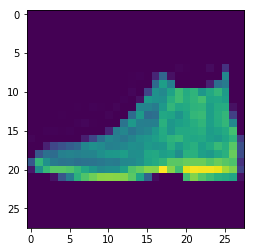

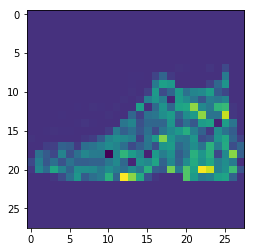

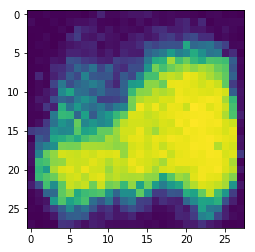

In [59]:
if __name__=="__main__":
    gc.collect()
    print("noise: speckle, hidden_nodes: 1000, learning_rate : 0.1, batch : 60000, number of iteration : 100")
    main("speckle",1000,0.1,60000,100)

In [34]:
import gc

noise: poisson, hidden_nodes: 1000, learning_rate : 0.1, batch : 60000, number of iteration : 100
Network dimensions are:[784, 1000, 784]
learning Rate is:  0.1
Train data is


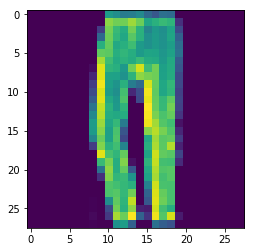

THe batch is 60000
MSE Cost at iteration 0 is: 0.19543
MSE Cost at iteration 0 validation error is 0.09360
Cross entropy Cost at iteration 0 is: 168.34179
Cross entropy Cost at iteration 0 validation error is 249.32770
Train data noisy


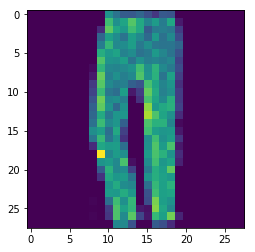

Train data predicted


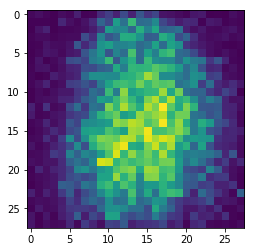

validation data noisy


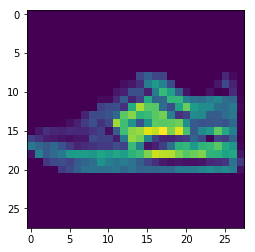

validation data predicted


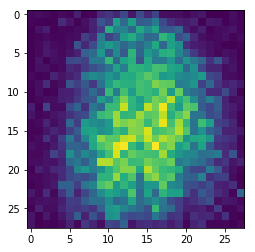

MSE Cost at iteration 10 is: 0.07322
MSE Cost at iteration 10 validation error is 0.07146
Cross entropy Cost at iteration 10 is: 198.48726
Cross entropy Cost at iteration 10 validation error is 195.35517
Train data noisy


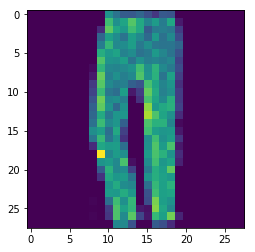

Train data predicted


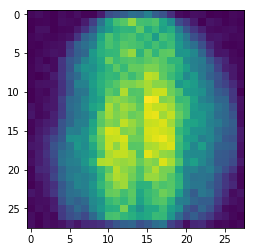

validation data noisy


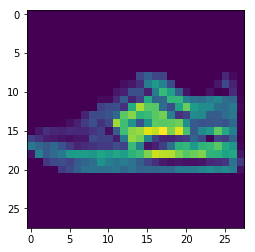

validation data predicted


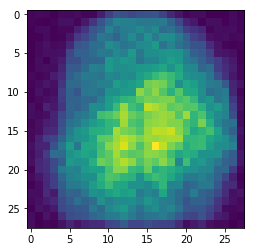

MSE Cost at iteration 20 is: 0.05904
MSE Cost at iteration 20 validation error is 0.05782
Cross entropy Cost at iteration 20 is: 178.76289
Cross entropy Cost at iteration 20 validation error is 177.19681
Train data noisy


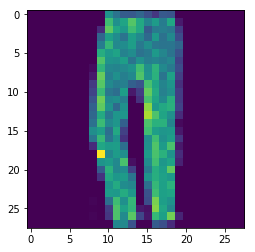

Train data predicted


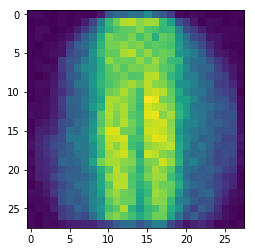

validation data noisy


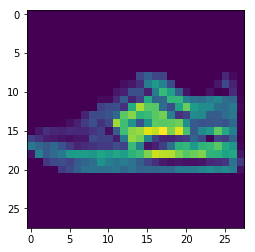

validation data predicted


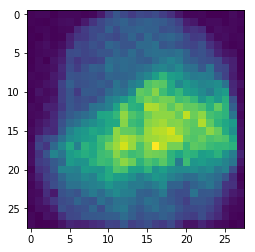

MSE Cost at iteration 30 is: 0.05038
MSE Cost at iteration 30 validation error is 0.04971
Cross entropy Cost at iteration 30 is: 166.27236
Cross entropy Cost at iteration 30 validation error is 165.43669
Train data noisy


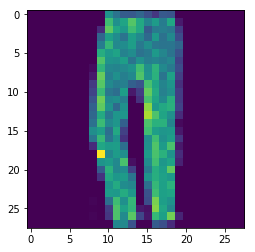

Train data predicted


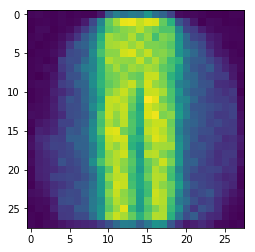

validation data noisy


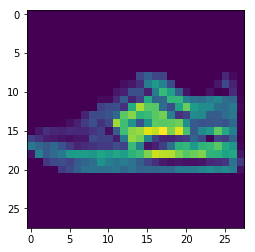

validation data predicted


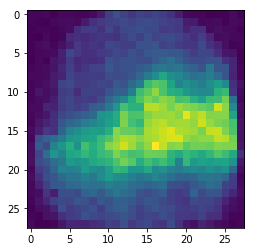

MSE Cost at iteration 40 is: 0.04557
MSE Cost at iteration 40 validation error is 0.04519
Cross entropy Cost at iteration 40 is: 158.86890
Cross entropy Cost at iteration 40 validation error is 158.31046
Train data noisy


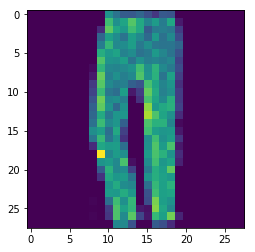

Train data predicted


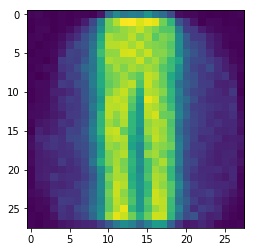

validation data noisy


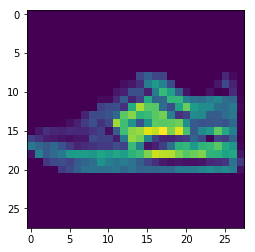

validation data predicted


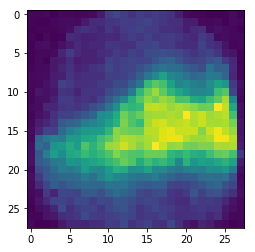

MSE Cost at iteration 50 is: 0.04264
MSE Cost at iteration 50 validation error is 0.04240
Cross entropy Cost at iteration 50 is: 154.20268
Cross entropy Cost at iteration 50 validation error is 153.83096
Train data noisy


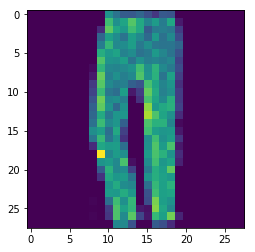

Train data predicted


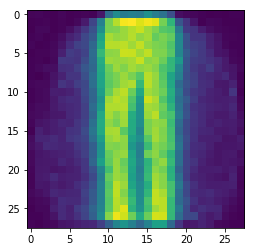

validation data noisy


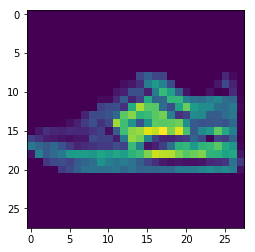

validation data predicted


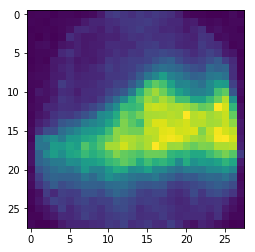

MSE Cost at iteration 60 is: 0.04056
MSE Cost at iteration 60 validation error is 0.04038
Cross entropy Cost at iteration 60 is: 150.93024
Cross entropy Cost at iteration 60 validation error is 150.70560
Train data noisy


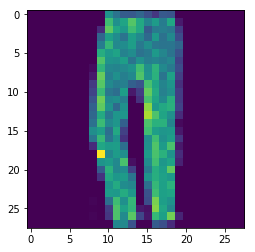

Train data predicted


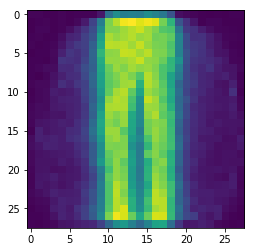

validation data noisy


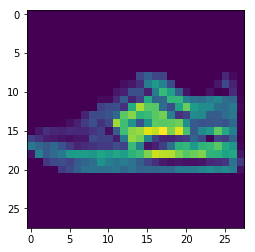

validation data predicted


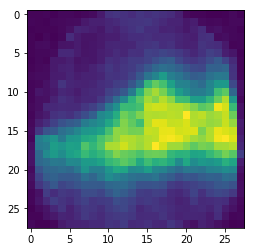

MSE Cost at iteration 70 is: 0.03886
MSE Cost at iteration 70 validation error is 0.03872
Cross entropy Cost at iteration 70 is: 148.36693
Cross entropy Cost at iteration 70 validation error is 148.24326
Train data noisy


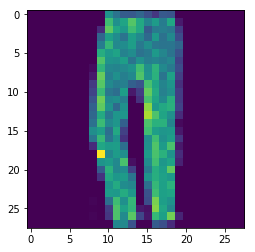

Train data predicted


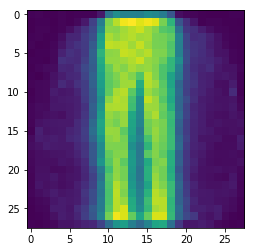

validation data noisy


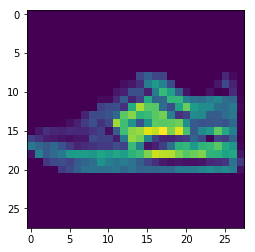

validation data predicted


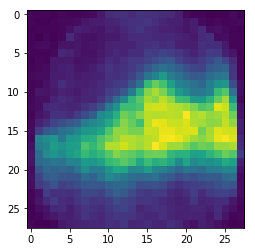

MSE Cost at iteration 80 is: 0.03737
MSE Cost at iteration 80 validation error is 0.03726
Cross entropy Cost at iteration 80 is: 146.18045
Cross entropy Cost at iteration 80 validation error is 146.12284
Train data noisy


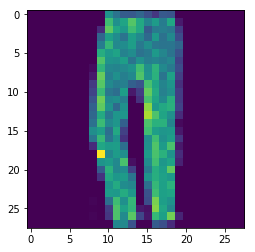

Train data predicted


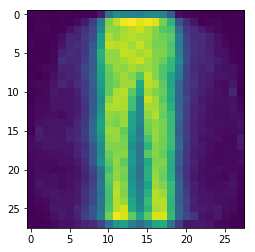

validation data noisy


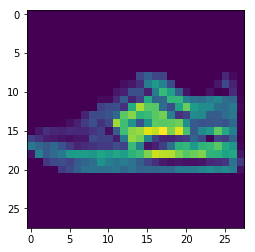

validation data predicted


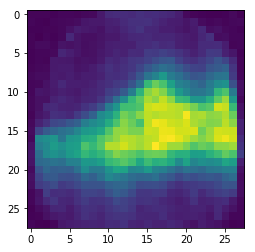

MSE Cost at iteration 90 is: 0.03603
MSE Cost at iteration 90 validation error is 0.03594
Cross entropy Cost at iteration 90 is: 144.21836
Cross entropy Cost at iteration 90 validation error is 144.20632
Train data noisy


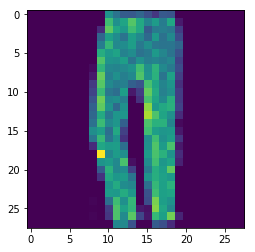

Train data predicted


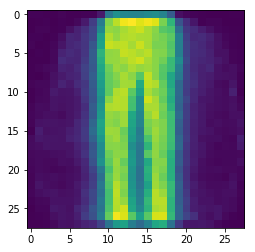

validation data noisy


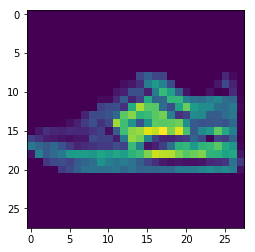

validation data predicted


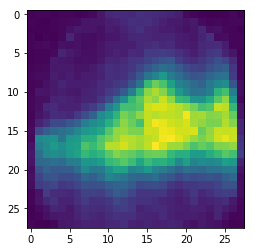

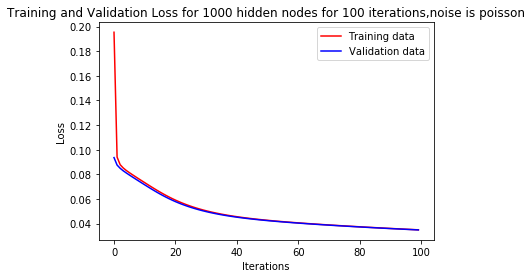

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in exp


Train data noiseless and noisy


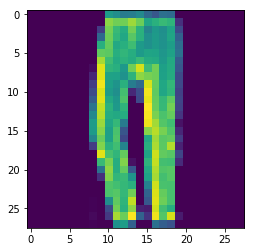

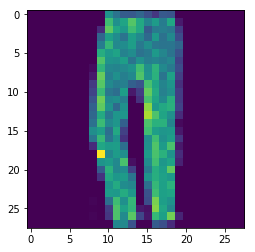

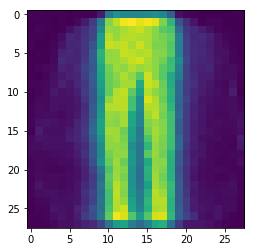

Val data noiseless and noisy


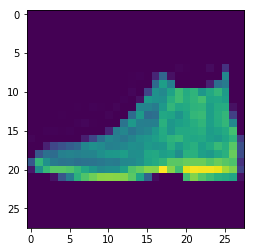

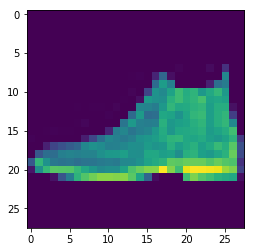

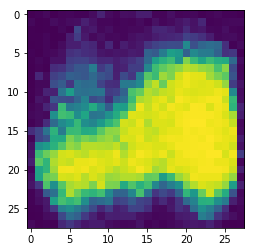

In [61]:
if __name__=="__main__":
    gc.collect()
    print("noise: poisson, hidden_nodes: 1000, learning_rate : 0.1, batch : 60000, number of iteration : 100")
    main("poisson",1000,0.1,60000,100)

noise: gaussian, hidden_nodes: 1000, learning_rate : 0.1, batch :60000, number of iteration :100
Network dimensions are:[784, 1000, 784]
learning Rate is:  0.1
Train data is


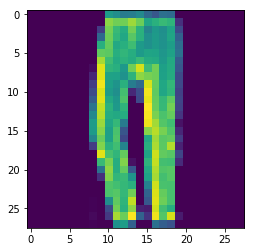

THe batch is 60000
MSE Cost at iteration 0 is: 0.19734
MSE Cost at iteration 0 validation error is 0.09646
Cross entropy Cost at iteration 0 is: 169.34001
Cross entropy Cost at iteration 0 validation error is 257.75979
Train data noisy


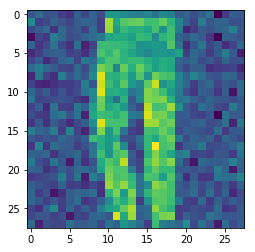

Train data predicted


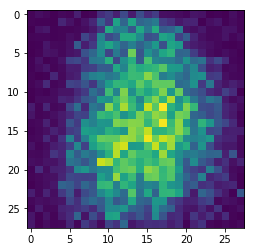

validation data noisy


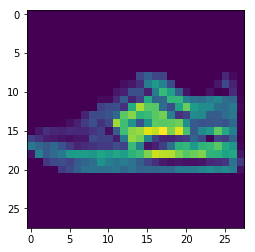

validation data predicted


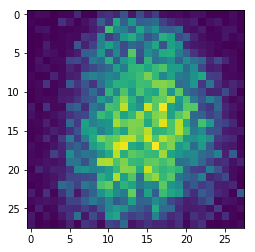

MSE Cost at iteration 10 is: 0.07667
MSE Cost at iteration 10 validation error is 0.07515
Cross entropy Cost at iteration 10 is: 202.80423
Cross entropy Cost at iteration 10 validation error is 200.05039
Train data noisy


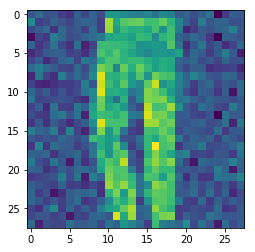

Train data predicted


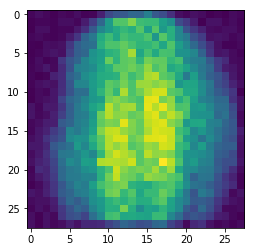

validation data noisy


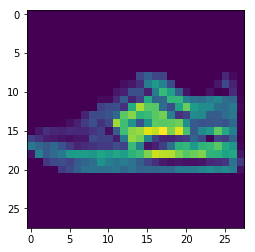

validation data predicted


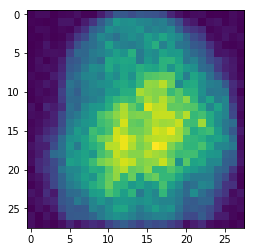

MSE Cost at iteration 20 is: 0.06392
MSE Cost at iteration 20 validation error is 0.06270
Cross entropy Cost at iteration 20 is: 181.93340
Cross entropy Cost at iteration 20 validation error is 187.53364
Train data noisy


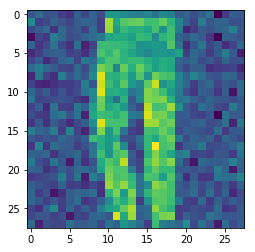

Train data predicted


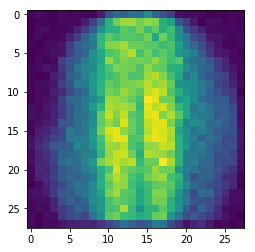

validation data noisy


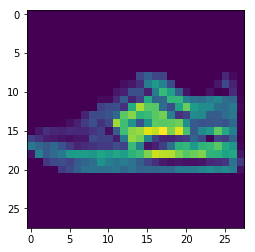

validation data predicted


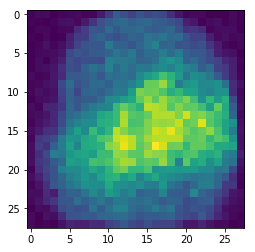

MSE Cost at iteration 30 is: 0.06601
MSE Cost at iteration 30 validation error is 0.06363
Cross entropy Cost at iteration 30 is: 135.66864
Cross entropy Cost at iteration 30 validation error is 221.72624
Train data noisy


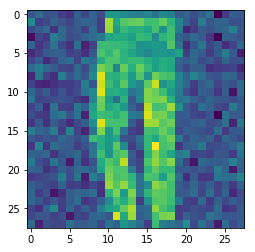

Train data predicted


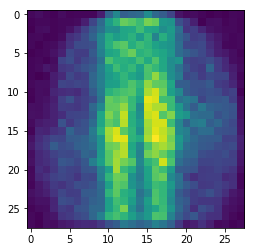

validation data noisy


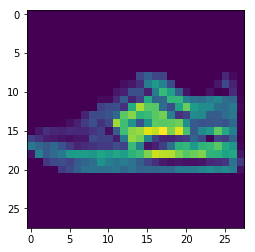

validation data predicted


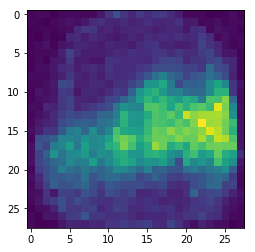

MSE Cost at iteration 40 is: 0.05262
MSE Cost at iteration 40 validation error is 0.05205
Cross entropy Cost at iteration 40 is: 140.16901
Cross entropy Cost at iteration 40 validation error is 192.36575
Train data noisy


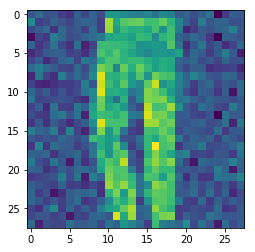

Train data predicted


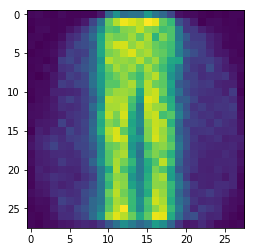

validation data noisy


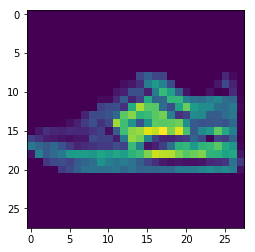

validation data predicted


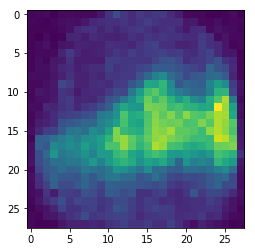

MSE Cost at iteration 50 is: 0.05017
MSE Cost at iteration 50 validation error is 0.04965
Cross entropy Cost at iteration 50 is: 131.08120
Cross entropy Cost at iteration 50 validation error is 192.20297
Train data noisy


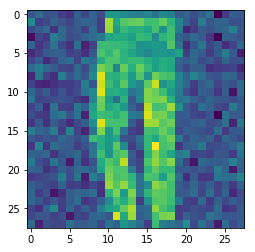

Train data predicted


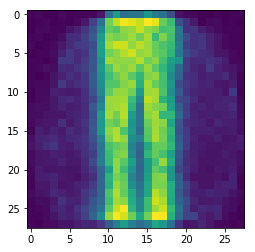

validation data noisy


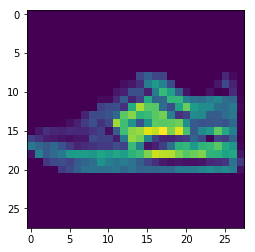

validation data predicted


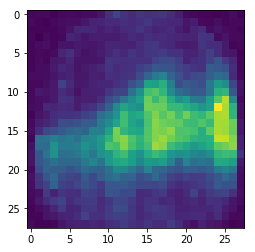

MSE Cost at iteration 60 is: 0.04672
MSE Cost at iteration 60 validation error is 0.04626
Cross entropy Cost at iteration 60 is: 129.61535
Cross entropy Cost at iteration 60 validation error is 184.53398
Train data noisy


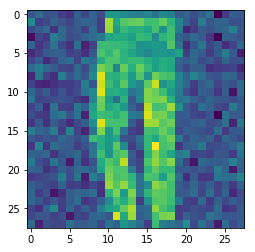

Train data predicted


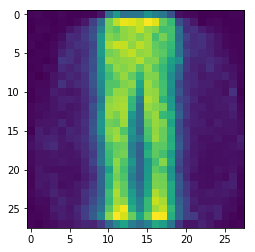

validation data noisy


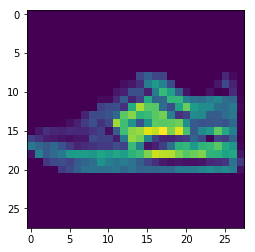

validation data predicted


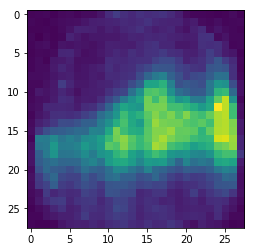

MSE Cost at iteration 70 is: 0.04442
MSE Cost at iteration 70 validation error is 0.04400
Cross entropy Cost at iteration 70 is: 127.23457
Cross entropy Cost at iteration 70 validation error is 180.50589
Train data noisy


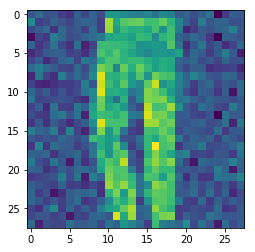

Train data predicted


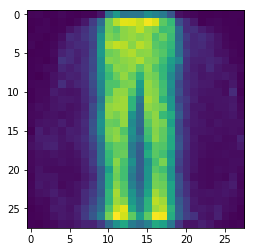

validation data noisy


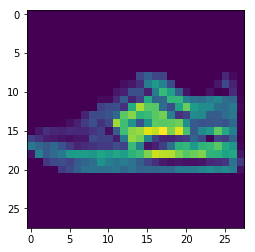

validation data predicted


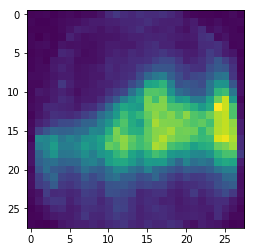

MSE Cost at iteration 80 is: 0.04249
MSE Cost at iteration 80 validation error is 0.04207
Cross entropy Cost at iteration 80 is: 125.47675
Cross entropy Cost at iteration 80 validation error is 176.71400
Train data noisy


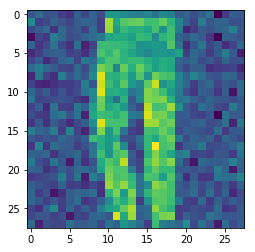

Train data predicted


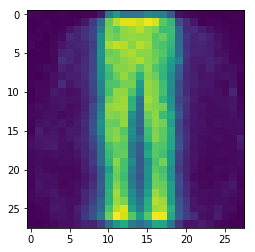

validation data noisy


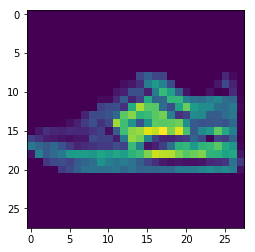

validation data predicted


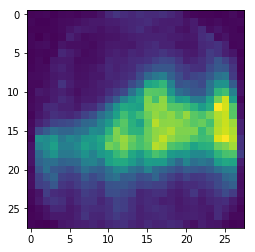

MSE Cost at iteration 90 is: 0.04076
MSE Cost at iteration 90 validation error is 0.04036
Cross entropy Cost at iteration 90 is: 124.29563
Cross entropy Cost at iteration 90 validation error is 173.14166
Train data noisy


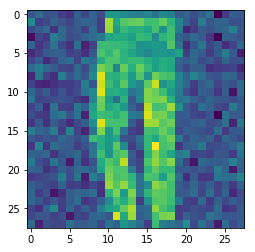

Train data predicted


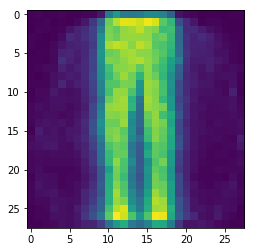

validation data noisy


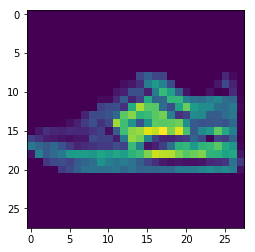

validation data predicted


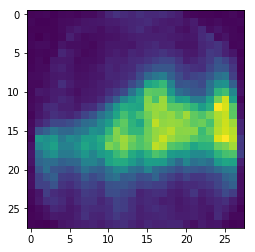

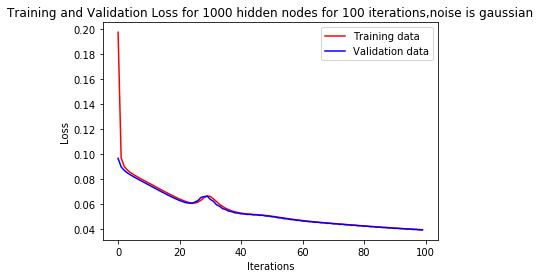

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in exp


Train data noiseless and noisy


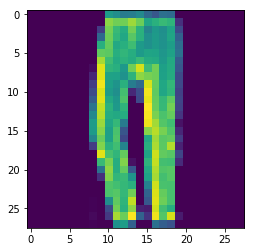

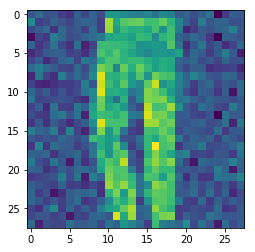

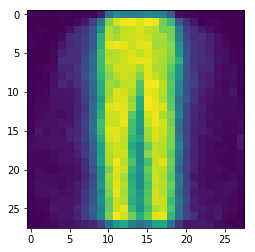

Val data noiseless and noisy


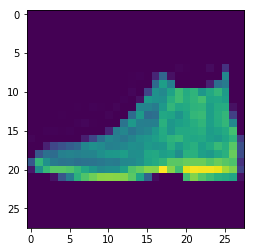

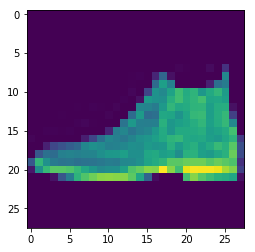

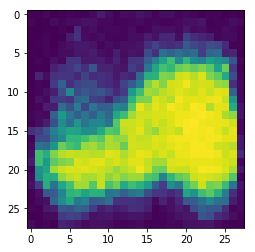

In [63]:
if __name__ == "__main__":
    gc.collect()
    print("noise: gaussian, hidden_nodes: 1000, learning_rate : 0.1, batch :60000, number of iteration :100")
    main("gaussian",1000,0.1,60000,100)